In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress
from IPython.core.display import display, HTML

from __future__ import unicode_literals

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
# Load wrangled data saved in .csv files.
sosg = pd.read_csv('data/sessions.csv', index_col=0)
posg = pd.read_csv('data/pilots.csv', index_col=0)
uosg = pd.read_csv('data/units.csv', index_col=0)

# Drop experiments with at least 8 tasks but less than 8 posg.
sosg = sosg[sosg.experiment != 'exp1']
posg = posg[posg.experiment != 'exp1']
uosg = uosg[uosg.experiment != 'exp1']
sosg = sosg[sosg.experiment != 'exp2']
posg = posg[posg.experiment != 'exp2']
uosg = uosg[uosg.experiment != 'exp2']
sosg = sosg[sosg.experiment != 'exp3']
posg = posg[posg.experiment != 'exp3']
uosg = uosg[uosg.experiment != 'exp3']

# Check for spurious data due to bugs and drop them
sosg = sosg.drop(['rp.session.radical.mturilli.017128.0000', 
                  'rp.session.radical.mturilli.017139.0003',
#                   'rp.session.radical.mturilli.017131.0005',  # outlier Tq
                  'rp.session.radical.mturilli.017230.0003',  # outlier TTC (Tr)
                  'rp.session.radical.mturilli.017212.0011',  # inconsistency in concurrency
                  'rp.session.radical.mturilli.017223.0000',  # inconsistency in concurrency
                  'rp.session.radical.mturilli.017228.0001'])  # inconsistency in concurrency
#                   'rp.session.radical.mturilli.017229.0003']) # inconsistency in concurrency 

posg = posg[posg.sid != 'rp.session.radical.mturilli.017139.0003']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017128.0000']
# posg = posg[posg.sid != 'rp.session.radical.mturilli.017131.0005']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017230.0003']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017212.0011']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017223.0000']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017228.0001']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017229.0003']

uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017139.0003']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017128.0000']
# uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017131.0005']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017230.0003']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017212.0011']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017223.0000']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017228.0001']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017229.0003']

# Derive number of uosg requested and number of uosg 
# rescheduled due to pilot halted/migrated by condor
sosg.loc[(sosg['nunit'] >= 8   ) & (sosg['nunit'] < 16  ), 'nunit_requested'] = 8
sosg.loc[(sosg['nunit'] >= 16  ) & (sosg['nunit'] < 32  ), 'nunit_requested'] = 16
sosg.loc[(sosg['nunit'] >= 32  ) & (sosg['nunit'] < 64  ), 'nunit_requested'] = 32
sosg.loc[(sosg['nunit'] >= 64  ) & (sosg['nunit'] < 128 ), 'nunit_requested'] = 64
sosg.loc[(sosg['nunit'] >= 128 ) & (sosg['nunit'] < 256 ), 'nunit_requested'] = 128
sosg.loc[(sosg['nunit'] >= 256 ) & (sosg['nunit'] < 512 ), 'nunit_requested'] = 256
sosg.loc[(sosg['nunit'] >= 512 ) & (sosg['nunit'] < 1024), 'nunit_requested'] = 512
sosg.loc[(sosg['nunit'] >= 1024) & (sosg['nunit'] < 2048), 'nunit_requested'] = 1024
sosg.loc[(sosg['nunit'] >= 2048) & (sosg['nunit'] < 4096), 'nunit_requested'] = 2048

sosg['nunit_rescheduled'] = sosg['nunit'] - sosg['nunit_requested']

# Eliminate spurious runs with number of pilots > number of units
sosg = sosg[sosg.npilot <= sosg.nunit_requested]
posg_completed = posg[posg.sid.isin(sosg.sid)]
uosg_completed = uosg[uosg.sid.isin(sosg.sid)]

In [4]:
print 'Total number of successful runs: %s' % sosg.shape[0]
print 'Total number of pilots: %s' % posg.shape[0]
print 'Total number of units: %s' % uosg.shape[0]

Total number of successful runs: 287
Total number of pilots: 40056
Total number of units: 153837


# Definitions

* Characteristics:
  * **Homogeneity** (of at least two instances of an entity): Given two instances of an entity with at least one property, the two instances are said to be homogeneous when their property has the same values. 
  * **Heterogeneity** (of at least two instances of an entity): Given two entities with at least one property,  the two entities are said to be homogeneous when their property has different values. 
  * **Dynamism** (of at least a property of an entity's instance): Given an entity with at least one property, the dynamism of the entity's property is defined as the variation of that property's value over time. 
* Entities:
  * **Task** (in this paper): a unit of computation with a well-defined number of computing operations. 
  * **Workload**: a set of tasks that can be executed concurrently.
  * **Pilot**: a resource placeholder enabling multi-stage scheduling of tasks, described (in this paper) by the tuple &lt;number of cores; duration; host> 
  * **Hosts**: a provider of a resources, i.e., sets of consumables.
* **Run** (in this paper): a tuple &lt;Workload; number of pilots; host>
* **Experiment**: set of runs


# Entities' instances of this paper

* **Task**: [Synapse simulation of an AMBER task requiring 1715750072310 operations (as profiled with Synapsy)]
* **Workload**: [128 tasks, 256 tasks, 512 tasks, 1024 tasks, 2048 tasks]
* **Pilot**: [single core with no walltime; gorups of 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
* **Host** = ['XSEDE OSG Virtual Cluster (XOVC)', 
    'CRUSH.OSG', 'campuscluster.illinois.edu', 'local', 'mwt2.org',
    'bu.edu', 'fnal.gov', 'phys.uconn.edu', 'panther.net', 'iu.edu',
    'hep.wisc.edu', 'n0x.10.2.x.x', 'aglt2.org', 'nodo',
    'usatlas.bnl.gov', 'research.northwestern.edu', 'chtc.wisc.edu',
    'its.osg', 'unl.edu', 'cl.iit.edu', 'rcac.purdue.edu',
    'icecube.wisc.edu', 'crane.hcc.unl.edu', 'tusker.hcc.unl.edu',
    'ucsd.edu', 'colorado.edu', 'palmetto.clemson.edu',
    'sandhills.hcc.unl.edu', 'cmsaf.mit.edu', 'cms.ucdavis.edu',
    'grid.uchicago.edu', 'compute', 'red.hcc.unl.edu']
    
# Experiments of this paper

| Experiment | <center>workload</center>                                                 | #Pilots |
|:----------:|--------------------------------------------------------------------------:|:--------|
| 1          | 8,16,32,64,128,256,512<span style="color:white">..................</span> | 8       |
| 2          |   16,32,64,128,256,512,1024<span style="color:white">.........</span>     | 16      |
| 3          |      32,64,128,256,512,1024,2048                                          | 32      |
| 4          |         64,128,256,512,1024,2048                                          | 64      |
| 5          |            128,256,512,1024,2048                                          | 128     |
| 6          |                256,512,1024,2048                                          | 256     |
| 7          |                    512,1024,2048                                          | 512     |
| 8          |                        1024,2048                                          | 1024    |
| 9          |                             2048                                          | 2048    |



# Measures of Heterogeneity and Dynamism

* Total Time to Completion ($TTC$): Workload
* Total Queuing Time ($TTQ$): Workload
* Total Pilot Running Time ($TTR$): Workload
* Queuing Time ($T_q$): Pilot
* Running Time ($T_r$): Pilot
* Execution Time ($T_x$): Task

# Measures of Dynamism?

* Number of concurrent Workloads ($C_w$): Workload
* Number of concurrent (used) Pilots ($C_p$): Workload
* Number of concurrent (used) Hosts ($C_h$): Workload
* Number of concurrent (executed) Tasks ($C_t$): Workload

# (Possible) Diagrams of the Measures of Dynamism

Template to define dynamism:

{E,R,M} 

- E = Entity
- R = Resource
- M = Measure

The distribution of M measures the dynamism of E on R


| ID  | Entity   | Resource | Measure   | Plot                                    |Description |
|:----|:---------|:---------|:----------|:----------------------------------------|:-----------|
| 1   | Workload | XOVC     | $TTC$     | Histogram: x = $TTC$ (s); y = Frequency | For every experiment, the same instance of each run of each experiment is sequentially submitted to XOVC multiple times. The distribution of $TTC$ measures the dynamism of that instance of a run of a workload on XOVC. |
| 2   | Workload | XOVC     | $TTQ$     | Histogram: x = $TTQ$ (s); y = Frequency | As 1 but with $TTQ$. |
| 3   | Workload | XOVC     | $TTX$     | Histogram: x = $TTX$ (s); y = Frequency | As 1 but with $TTX$. |
| 4   | Pilot    | XOVC     | $T_q$     | Histogram: x = $T_q$ (s); y = Frequency | For every experiment, the same instance of pilot (&lt;1; unspecified; XOVC>) is sequentially submitted to XOVC. The distribution of $T_q$ measures the dynamism of that instance of a pilot on XOVC. (We are not sure what we are measuring: the time the pilot has been waiting on the broker (the broker does late binding of jobs to hosts) or the time the pilot has been waiting on a host (the broker does early binding of jobs to hosts). I think the former and I have strated accumulating data/evidence for it.) |
| 5   | Pilot    | XOVC     | $T_r$     | Histogram: x = $T_r$ (s); y = Frequency | For every experiment, the same instance of pilot (&lt;1; unspecified; XOVC>) is sequentially submitted to XOVC. The distribution of $T_r$ measures the dynamism of that instance of a pilot on XOVC. |
| 6   | Task    | XOVC     | $T_x$     | Histogram: x = $T_x$ (s); y = Frequency | For every experiment, the same instance of task (1715750072310 operations) is sequentially executed on the same host multiple times. The distribution of $T_x$ measures the dynamism of that instance of task on XOVC. |
| ~~7~~   | ~~Workload~~ | ~~Host~~     | ~~$TTC$~~     | ~~Histogram: x = $TTC$ (s); y = Frequency~~ | ~~For every run of every experiment, multiple instances of the same run are sequentially executed on a host. The histogram describes the dynamism of that run's workload on that host as measured by the distribution of $TTC$. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed on the same host and the degree of concurrency (i.e., the number of pilots/cores) with which those tasks are executed on that host.)~~ |
| ~~8~~   | ~~Workload~~ | ~~Host~~     | ~~$TTQ$~~     | ~~Histogram: x = $TTQ$ (s); y = Frequency~~ | ~~As 6 but for $TTQ$.~~ |
| ~~9~~   | ~~Workload~~ | ~~Host~~     | ~~$TTX$~~     | ~~Histogram: x = $TTX$ (s); y = Frequency~~ | ~~As 6 but for $TTX$.~~ |
| 10  | Pilot    | Host     | $T_r$     | Histogram: x = $T_r$ (s); y = Frequency | For every experiment, the same instance of pilot (&lt;1; unspecified; XOVC>) become sequentially active on the same host. The distribution of $T_r$ describes the dynamism of that instance of a pilot on that host as measured by $T_r$. |
| 11  | Task     | Host     | $T_x$     | Histogram: x = $T_x$ (s); y = Frequency | For every experiment, the same instance of task (1715750072310 operations) is sequentially executed on the same host multiple times. The the distribution of $T_x$ measures the dynamism of that instance of task on that host. |


To be considered after dynamism:

| ID  | Entity   | Resource | Measure   | Plot                                    |Description |
|:----|:---------|:---------|:----------|:----------------------------------------|:-----------|
| 11  | Workload | XOVC     | $C_w$     | Histogram: x = Number of concurrent active workloads; y = Frequency | For every run of every experiment, for every experiment run, multiple instances of the same run are concurrently submitted to XOVC. The histogram describes the dynamism of that goup of runs' workload on XOVC as measured by the number of concurrent active (i.e., tasks of that workload are being executed) workloads ($C_w$) active at runtime |
| 12  | Workload | XOVC     | $C_p$     | Histogram: x = Number of concurrent active pilots; y = Frequency | For every run of every experiment, for every experiment run, multiple instances of the same run are sequentially submitted to XOVC. The histogram describes the dynamism of that run's workload on XOVC as measured by the number of concurrent active (i.e., pilots are alive and ready to execute/executing tasks) pilots active at runtime ($C_p$) |
| 13  | Workload | XOVC     | $C_h$     | Histogram: x = Number of concurrent active hosts; y = Frequency | For every run of every experiment, for every experiment run, multiple instances of the same run are sequentially submitted to XOVC. The histogram describes the dynamism of that run's workload on XOVC as measured by the number of concurrent active hosts (i.e., hosts where tasks are being executed) at runtime ($C_h$) |
| 14  | Workload | XOVC     | $C_t$     | Histogram: x = Number of concurrent active tasks; y = Frequency | For every run of every experiment, for every experiment run, multiple instances of the same run are sequentially submitted to XOVC. The histogram describes describes the dynamism of that run's workload on XOVC as measured by the number of concurrent active (i.e., being executed) tasks at runtime ($C_t$)  |


Notes:
* Do we have $T_q$ at host level?
* Pilots are submitted to XOVC; run on a host.
* Tasks are scheduled on a pilot; executed on a host.


# (Possible) Diagrams of the Measures of Heterogeneity

Template to define homogeneity/heterogeneity:

{E,R,M} 

- E = Entity
- R = Resource
- M = Measure

The distribution of M measures the heterogeneity of E on R

| ID  | Entity   | Resource | Measure   | Plot                                    | Description |
|:----|:---------|:---------|:----------|:----------------------------------------|:------------|
| ~~1~~   | ~~Workload~~ | ~~XOVC~~     | ~~$TTC$~~     | ~~Histogram: x = $TTC$ (s); y = Frequency~~ | ~~For every run of every experiment, the same instance of each run for each experiment is concurrently submitted to XOVC multiple times. The histogram describes the heterogeneity of each instance of each run of each workload on XOVC as measured by the distribution of $TTC$. (This is possible but I am not sure we have enough data for actually plotting it).~~ |
| ~~2~~   | ~~Workload~~ | ~~XOVC~~     | ~~$TTQ$~~     | ~~Histogram: x = $TTQ$ (s); y = Frequency~~ | ~~As 1 but for $TTQ$.~~ |
| ~~3~~   | ~~Workload~~ | ~~XOVC~~     | ~~$TTX$~~     | ~~Histogram: x = $TTX$ (s); y = Frequency~~ | ~~As 1 but for $TTX$.~~ |
| 4   | Pilot    | XOVC     | $T_q$     | Histogram: x = $T_q$ (s); y = Frequency | For every experiment, multiple instances of the same pilot (&lt;1; unspecified; XOVC>) are concurrently submitted to XOVC. The distribution of $T_q$ measures the heterogeneity of that pilot on XOVC. |
| 5   | Pilot    | XOVC     | $T_r$     | Histogram: x = $T_r$ (s); y = Frequency | For every experiment, multiple instances of the same pilot (&lt;1; unspecified; XOVC>) are concurrently submitted to XOVC. The distribution of $T_r$ measures the heterogeneity of that pilot on XOVC. |
| 6   | Task    | XOVC     | $T_x$     | Histogram: x = $T_x$ (s); y = Frequency | For every experiment, multiple instances of the same task (1715750072310 operations) are concurrently executed on XOVC. The distribution of the $T_x$ of these instances measures the dynamism of that task on XOVC. |
| 7   | Workload | Host     | $TTC$     | Histogram: x = $TTC$ (s); y = Frequency | For every run of every experiment, multiple instances of the same run are concurrently executed on a host. The histogram describes the heterogeneity of that run's workload on that host as measured by the distribution of $TTC$. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed on the same host and the degree of concurrency (i.e., the number of pilots/cores) with which those tasks are executed on that host.) | 
| 8   | Workload | Host     | $TTQ$     | Histogram: x = $TTQ$ (s); y = Frequency | As 6 but for $TTQ$. |
| 9   | Workload | Host     | $TTX$     | Histogram: x = $TTX$ (s); y = Frequency | As 6 but for $TTX$. |
| 10   | Pilot    | Host     | $T_r$     | Histogram: x = $T_r$ (s); y = Frequency | For every run of every experiment, for every type of pilot (&lt;1; unspecified; host>), multiple instances of the same pilot become concurrently active on the same host. The histogram describes the heterogeneity of that pilot on that host as measured by the distribution of $T_r$. | 
| 11  | Task     | Host     | $T_x$     | Histogram: x = $T_x$ (s); y = Frequency | For every run of every experiment, for every type of task (only one type of task in this paper), multiple instances of the same task are concurrently executed on the same host. The histogram describes the heterogeneity of the task on that host as measured by the distribution of $T_x$. |

# (Possible) Correlations

* Number of concurrently requested pilots; number of concurrent hosts in use: positively correlates.
* Number of concurrently requested pilots; number of concurrent active pilots: Unknown.
* Number of concurrently requested pilots; number of concurrent tasks in execution: Unknown.


* Number of concurrent Hosts in use; number of concurrent active pilots: Unknown.
* Number of concurrent Hosts in use; number of concurrent tasks in execution: Unknown.


* Number of concurrently requested pilots; workload $TTC$: unknown.
* Number of concurrently requested pilots; workload $TTQ$: unknown.
* Number of concurrently requested pilots; workload $TTR$: unknown.
* Number of concurrently requested pilots; pilot $T_r$: unknown.
* Number of concurrently requested pilots; task $T_x$: unknown.


* Ratio pilot/tasks; workload $TTC$: unknown.
* Ratio pilot/tasks; workload $TTQ$: unknown.
* Ratio pilot/tasks; workload $TTR$: unknown.
* Ratio pilot/tasks; pilot $T_r$: unknown.
* Ratio pilot/tasks; task $T_x$: unknown.

# Dynamism

In [5]:
# Drop runs that did not manage to execute all the requested units. 
# We will want to plot these data: given a number of pilots and a 
# number of units, how likely is that all the units will be executed 
# before all the pilots fail/disappear?
sosg_completed = sosg.loc[sosg.nunit_requested <= sosg.nunit_done]

# Eliminate the units and pilots of unsuccessful runs
posg_completed = posg[posg.sid.isin(sosg.sid)]
uosg_completed = uosg[uosg.sid.isin(sosg.sid)]

In [6]:
ttc = sosg_completed[
    ['npilot','TTC','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'TTC':{'TTC_mean':'mean','TTC_std':'std'}})
ttc.columns = ttc.columns.droplevel(0)
ttc = ttc.reset_index()

ttx = sosg_completed[
    ['npilot','U_AGENT_EXECUTING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'U_AGENT_EXECUTING':{'TTX_mean':'mean','TTX_std':'std'}})
ttx.columns = ttx.columns.droplevel(0)
ttx = ttx.reset_index()

ttq = sosg_completed[
    ['npilot','P_LRMS_QUEUING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'P_LRMS_QUEUING':{'TTQ_mean':'mean','TTQ_std':'std'}})
ttq.columns = ttq.columns.droplevel(0)
ttq = ttq.reset_index()

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [7]:
print "Number of runs for each combination of #pilots and #units\nTable: rows = #units; columns = #pilots"
# Calculate how many runs we have for each #tasks/#pilots combination
vs = {}
idx = []
ns = sorted(sosg_completed.nunit_requested.unique().tolist())

for n in ns:
    vs[int(n)] = []
    idx.append(int(n))
    for m in ns:
        v = sosg_completed[(sosg_completed.npilot == n) & (sosg_completed.nunit_requested == m)].nunit_requested.value_counts().tolist()
        if v:
            vs[int(n)].append(int(v[0]))
        else:
            vs[int(n)].append(np.nan)

display(pd.DataFrame(vs, index=idx))

Number of runs for each combination of #pilots and #units
Table: rows = #units; columns = #pilots


,8,16,32,64,128,256,512,1024,2048
8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,6.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
64,8.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN
128,7.0,6.0,8.0,6.0,6.0,NaN,NaN,NaN,NaN
256,3.0,7.0,5.0,7.0,4.0,3.0,NaN,NaN,NaN
512,2.0,3.0,3.0,3.0,4.0,4.0,NaN,NaN,NaN
1024,NaN,NaN,2.0,4.0,3.0,1.0,NaN,1.0,NaN
2048,NaN,NaN,3.0,2.0,NaN,1.0,NaN,NaN,1.0


## Dynamism 1: $TTC$ distribution of workloads on XOVC  

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=8.0, right=8.0
  'left=%s, right=%s') % (left, right))


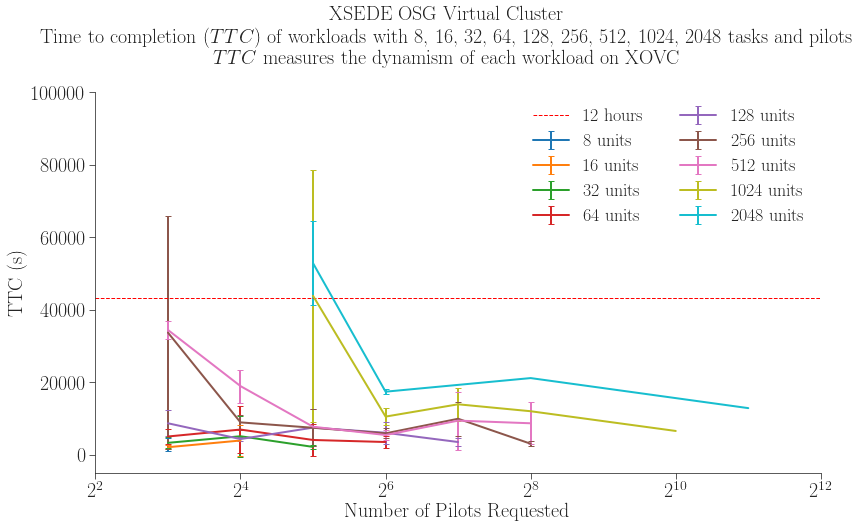

In [8]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Time to completion ($TTC$) of workloads with 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks and pilots'
title_measure = '$TTC$ measures the dynamism of each workload on XOVC'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)

fig.suptitle(title, y=1.05)

nus = ttx['nunit_requested'].unique()
nus.sort()

for nu in nus:
    color = colors.pop(0)
    ttc.loc[ttc['nunit_requested']==nu].plot(
        x='npilot', 
        y='TTC_mean', 
        yerr='TTC_std', 
        label=str(int(nu))+' units',
        color=color,
        ax=ax)
    
plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')


ax.legend(loc=1, ncol=2)
ax.set_xscale('log', basex=2)
ax.set_xlim(2**2, 2**12, auto=True)
ax.set_ylim(-5000, 100000)
ax.set_xlabel('Number of Pilots Requested')
ax.set_ylabel('TTC (s)')

## Dynamism 2: $TTX$ distribution of workloads on XOVC  

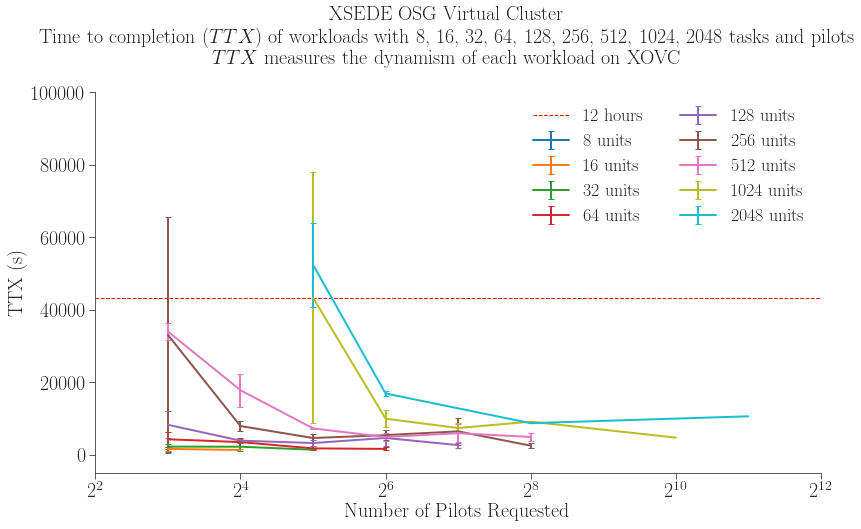

In [9]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Time to completion ($TTX$) of workloads with 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks and pilots'
title_measure = '$TTX$ measures the dynamism of each workload on XOVC'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, y=1.05)

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttx.loc[ttx['nunit_requested']==nu].plot(x='npilot', y='TTX_mean', yerr='TTX_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')

ax.legend(loc=1, ncol=2)
ax.set_xscale('log', basex=2)
ax.set_xlim(2**2, 2**12)
ax.set_ylim(-5000, 100000)
ax.set_xlabel('Number of Pilots Requested')
ax.set_ylabel('TTX (s)')

## Dynamism 3: $TTQ$ distribution of workloads on XOVC  

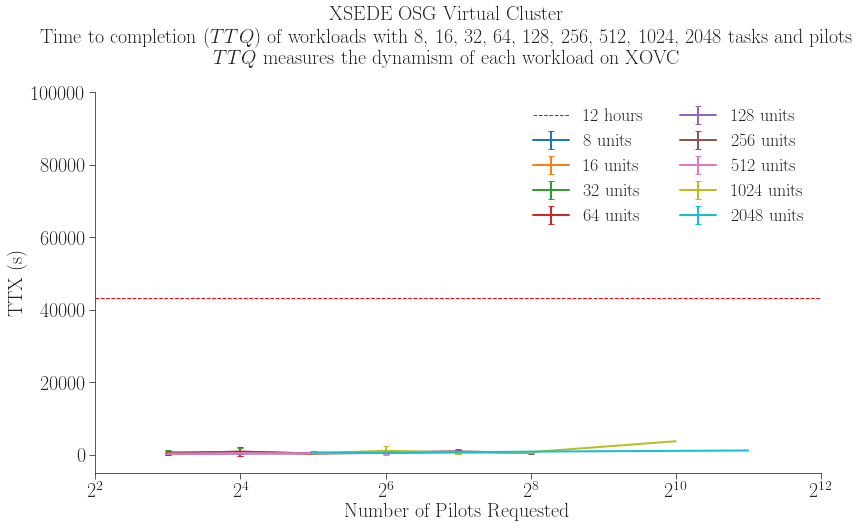

In [10]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Time to completion ($TTQ$) of workloads with 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks and pilots'
title_measure = '$TTQ$ measures the dynamism of each workload on XOVC'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, y=1.05)

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    ttq.loc[ttq['nunit_requested']==nu].plot(x='npilot', y='TTQ_mean', yerr='TTQ_std', 
                                             label=str(int(nu))+' units',
                                             color=colors.pop(0),
                                             ax=ax)

plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')

ax.legend(loc=1, ncol=2)
ax.set_xscale('log', basex=2)
ax.set_xlim(2**2, 2**12)
ax.set_ylim(-5000, 100000)
ax.set_xlabel('Number of Pilots Requested')
ax.set_ylabel('TTX (s)')

In [11]:
# Get one pilot for each submission (they are submitted in bulk) so to guarantee that:
# - pilot submissions are sequential;
# - each pilot executed at least one unit;
# - the pilot's units were successfully executed.

psample = posg.loc[(posg.P_LRMS_RUNNING > 1) & (posg.nunit > 1)]

tr = []
tq = []
for sid in sosg.sid:
    p = psample[psample.sid == sid].pid.tolist()
    if p:
        tr.append(psample[(psample.sid == sid) & 
                (psample.pid == p[0])].P_LRMS_RUNNING.tolist()[0])
        tq.append(psample[(psample.sid == sid) & 
                (psample.pid == p[0])].P_LRMS_QUEUING.tolist()[0])

pdynxovc = pd.DataFrame({'$T_r$': tr, '$T_q$': tq})

## Dynamism 4: $T_q$ distribution of pilot on XOVC  

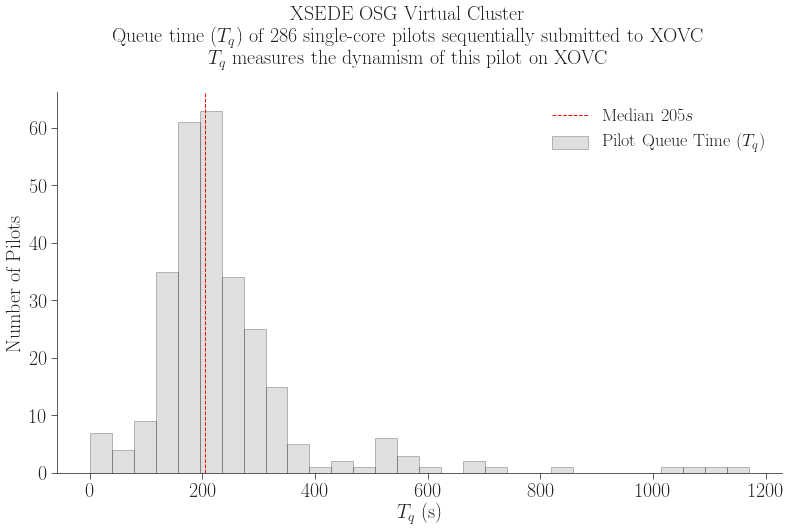

In [12]:
fig, ax = fig_setup()

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Queue time ($T_q$) of %s single-core pilots sequentially submitted to XOVC' % len(tq)
title_measure = '$T_q$ measures the dynamism of this pilot on XOVC'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, y=1.05)

pdynxovc[['$T_q$']].plot.hist(
    ax=ax, 
    color='gray', 
    bins=30, 
    alpha = 0.25)

plt.axvline(pdynxovc['$T_q$'].median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(0, 2000)
ax.set_xlabel('$T_q$ (s)')
ax.set_ylabel('Number of Pilots')
ax.legend(labels=['Median $%is$' % pdynxovc['$T_q$'].median(), 'Pilot Queue Time ($T_q$)'])

## Dynamism 5: $T_r$ distribution of pilot on XOVC  

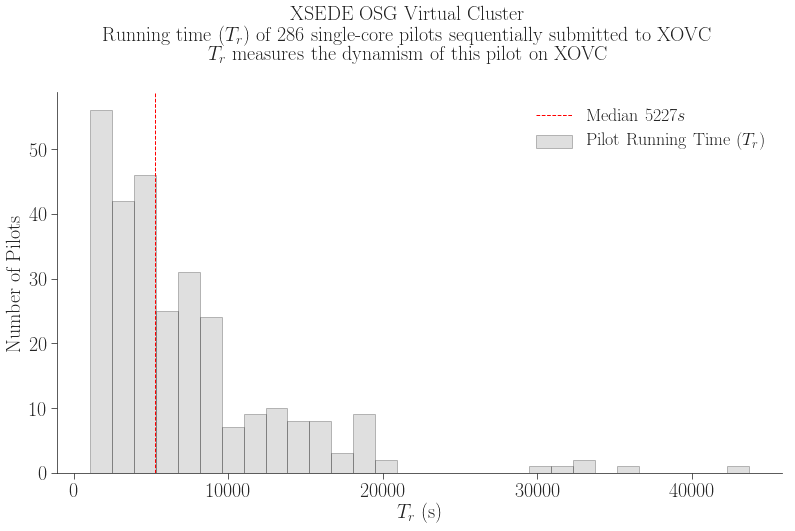

In [13]:
fig, ax = fig_setup()

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Running time ($T_r$) of %s single-core pilots sequentially submitted to XOVC' % len(tq)
title_measure = '$T_r$ measures the dynamism of this pilot on XOVC'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, y=1.05)

pdynxovc[['$T_r$']].plot.hist(
    ax=ax, 
    color='gray', 
    bins=30, 
    alpha = 0.25)

plt.axvline(pdynxovc['$T_r$'].median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(0, 2000)
ax.set_xlabel('$T_r$ (s)')
ax.set_ylabel('Number of Pilots')
ax.legend(labels=['Median $%is$' % pdynxovc['$T_r$'].median(), 'Pilot Running Time ($T_r$)'])

In [14]:
# Get one task for each submission so to guarantee that:
# - task submissions are sequential;
# - each task has succesfully executed.

tsample = uosg.loc[(uosg.U_AGENT_EXECUTING > 1) & (uosg.DONE > 1)]

tx = []
for sid in sosg.sid:
    t = tsample[tsample.sid == sid].uid.tolist()
    if t:
        tx.append(tsample[(tsample.sid == sid) & 
                (tsample.uid == t[0])].U_AGENT_EXECUTING.tolist()[0])

tdynxovc = pd.DataFrame({'$T_x$': tx})

## Dynamism 6: $T_x$ distribution of tasks on XOVC

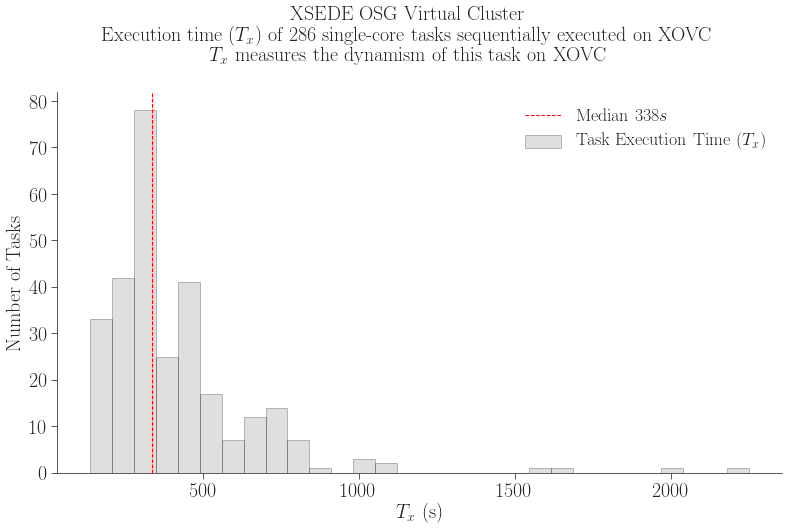

In [15]:
fig, ax = fig_setup()

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Execution time ($T_x$) of %s single-core tasks sequentially executed on XOVC' % len(tx)
title_measure = '$T_x$ measures the dynamism of this task on XOVC'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, y=1.05)

tdynxovc[['$T_x$']].plot.hist(
    ax=ax, 
    color='gray', 
    bins=30, 
    alpha = 0.25)

plt.axvline(tdynxovc['$T_x$'].median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.set_ylabel('Number of Tasks')
ax.legend(labels=['Median $%is$' % tdynxovc['$T_x$'].median(), 'Task Execution Time ($T_x$)'])

In [16]:
# For every session, get a single unit that completed execution on every used host
htr = pd.DataFrame()
for sid in sosg.sid:
    for host in psample[psample.sid == sid].hid.unique().tolist():
        if host == 'local':
            continue
        pilots = psample[(psample.sid == sid) &
                         (psample.hid == host)].pid.tolist()
        if pilots:
            htr = htr.append(psample[(psample.sid == sid) & 
                                     (psample.hid == host) &
                                     (psample.pid == pilots[0])])
htr.reset_index(drop=True, inplace=True)

## Dynamism 10: $T_r$ distribution of pilots on hosts

Number of pilots executed per host:
CRUSH.OSG                     164
campuscluster.illinois.edu    164
mwt2.org                      131
phys.uconn.edu                109
panther.net                    99
fnal.gov                       92
iu.edu                         87
usatlas.bnl.gov                87
aglt2.org                      86
chtc.wisc.edu                  67
nodo                           58
n0x.10.2.x.x                   56
bu.edu                         54
its.osg                        43
hep.wisc.edu                   35
dtype: int64


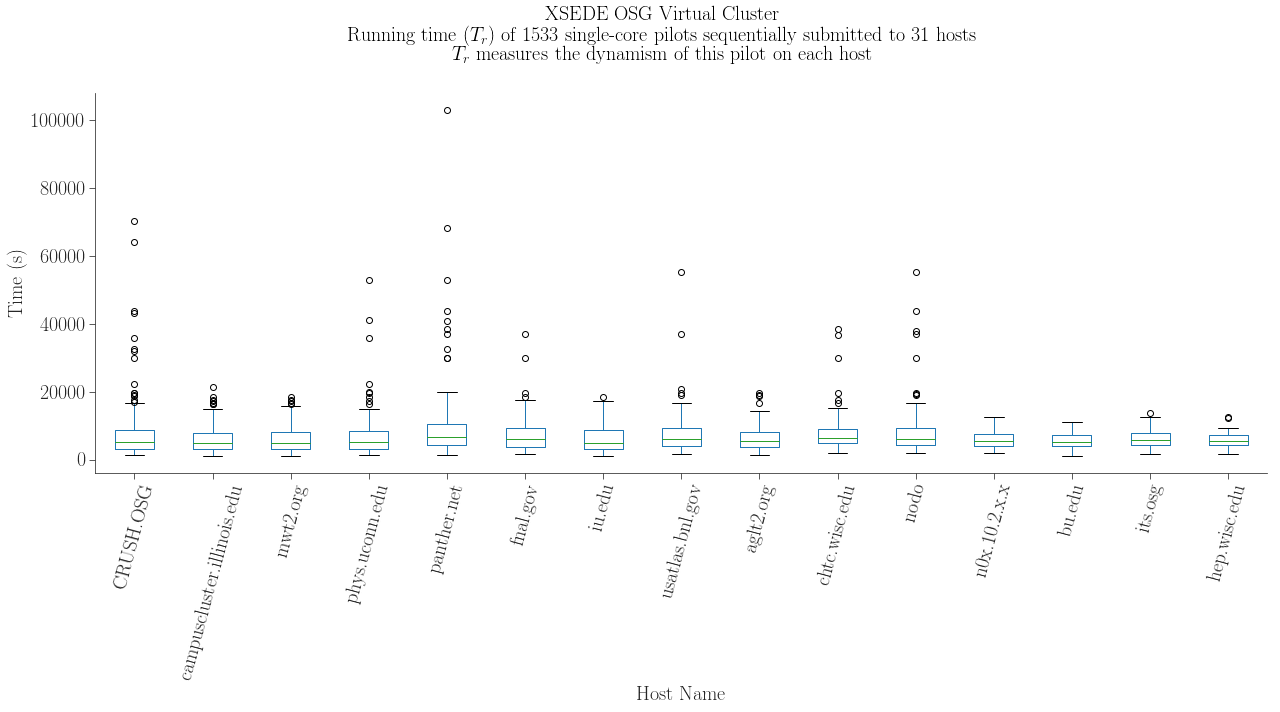

In [17]:
fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

grouped = htr.groupby('hid')
df = pd.DataFrame({col:vals['P_LRMS_RUNNING'] for col,vals in grouped})
counts = df.count()
counts = counts.sort_values(ascending=False)

print 'Number of pilots executed per host:'
print counts[:15]

df = df[counts.index]

df.iloc[:,:15].boxplot(ax=ax, rot=75, grid=False)

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Running time ($T_r$) of %s single-core pilots sequentially submitted to %s hosts' % (len(htr), len(htr.hid.unique().tolist()))
title_measure = '$T_r$ measures the dynamism of this pilot on each host'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, y=1.05, backgroundcolor='white', color='black')

ax.set_ylabel('Time (s)')
ax.set_xlabel('Host Name')


In [18]:
# For every session, get a single unit that completed execution on every used host
htx = pd.DataFrame()
for sid in sosg.sid:
    for host in tsample[tsample.sid == sid].hid.unique().tolist():
        if host == 'local':
            continue
        units = tsample[(tsample.sid == sid) &
                        (tsample.hid == host)].uid.tolist()
        if units:
            htx = htx.append(tsample[(tsample.sid == sid) & 
                                     (tsample.hid == host) &
                                     (tsample.uid == units[0])])
htx.reset_index(drop=True, inplace=True)

## Dynamism 11: $T_x$ distribution of tasks on hosts

Number of tasks executed per host:
CRUSH.OSG                     164
campuscluster.illinois.edu    164
mwt2.org                      131
phys.uconn.edu                109
panther.net                    99
fnal.gov                       92
iu.edu                         87
usatlas.bnl.gov                87
aglt2.org                      86
chtc.wisc.edu                  67
nodo                           57
n0x.10.2.x.x                   56
bu.edu                         54
its.osg                        43
hep.wisc.edu                   35
dtype: int64


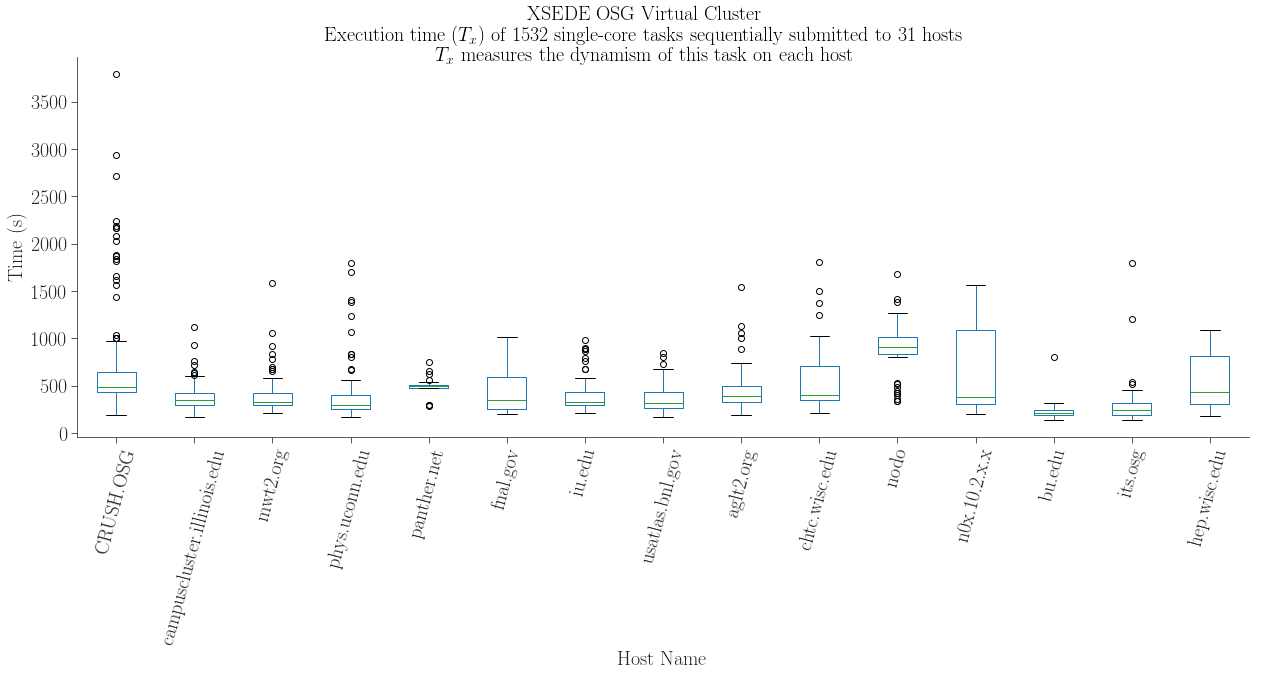

In [19]:
fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

grouped = htx.groupby('hid')
df = pd.DataFrame({col:vals['U_AGENT_EXECUTING'] for col,vals in grouped})
counts = df.count()
counts = counts.sort_values(ascending=False)

print 'Number of tasks executed per host:'
print counts[:15]

df = df[counts.index]

df.iloc[:,:15].boxplot(ax=ax, rot=75, grid=False)

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Execution time ($T_x$) of %s single-core tasks sequentially submitted to %s hosts' % (len(htx), len(htx.hid.unique().tolist()))
title_measure = '$T_x$ measures the dynamism of this task on each host'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, backgroundcolor='white', color='black')

ax.set_ylabel('Time (s)')
ax.set_xlabel('Host Name')


In [20]:
# Find units that:
# - have successfully executed
# - have executed concurrently on XOVC
usconc = pd.DataFrame()
npartition = 0

for s in sosg.sid.tolist():
    # Select the units in a session that have completed and 
    # sort them by the time they started to execute
    sus = uosg[(uosg.sid == s) & 
               (uosg.AGENT_EXECUTING > 1) & 
               (uosg.AGENT_STAGING_OUTPUT_PENDING > 1)].sort_values('AGENT_EXECUTING')
    sus = sus.reset_index(drop=True)
    
    # - Search for all the units in the selected units that executed concurrently. 
    #   Use a special case: all the units that executed concurrently before the
    #   shortest unit finished. Due to the large variation of Tx, multiple units
    #   finish in the time a single unit takes to execute. Strictly speaking, 
    #   these units are not executing concurrently. 
    # - Save the to a partition if they were more than 285 concurrent units.
    base = 0
    base_end = sus[['AGENT_STAGING_OUTPUT_PENDING']].min().tolist()[0]
    for i in sus.index.tolist():
        if sus.loc[i].AGENT_EXECUTING > base_end:
            npartition += 1
            sus = sus.assign(npartition=npartition)
            cunits = i-1
            sus = sus.assign(cunits=cunits)
            usconc = usconc.append(sus[base:i-1])
            break

# Find the session with most concurrent units
sc = usconc.sort_values('cunits', ascending=False)[0:1].sid.tolist()[0]

## Heterogeneity 6: TxTx distribution of tasks on XOVC

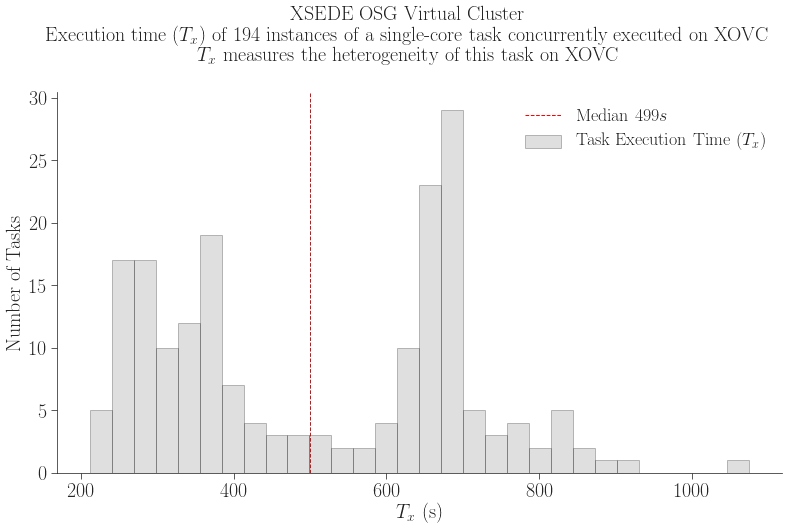

In [21]:
fig, ax = fig_setup()

usconcurrent = usconc[usconc.sid == sc]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Execution time ($T_x$) of %s instances of a single-core task concurrently executed on XOVC' % len(usconcurrent.uid.tolist())
title_measure = '$T_x$ measures the heterogeneity of this task on XOVC'
title = '%s\n%s\n%s' % (title_head, title_desc, title_measure)
fig.suptitle(title, y=1.05)

usconcurrent[['U_AGENT_EXECUTING']].plot.hist(
    ax=ax, 
    color='gray', 
    bins=30, 
    alpha = 0.25)

plt.axvline(usconcurrent['U_AGENT_EXECUTING'].median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.set_ylabel('Number of Tasks')
ax.legend(labels=['Median $%is$' % usconcurrent['U_AGENT_EXECUTING'].median(), 'Task Execution Time ($T_x$)'])